<a href="https://www.kaggle.com/code/dalloliogm/logistic-regression-xgboost-lightgbm-ensemble?scriptVersionId=230570438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rain prediction using three models

This notebook contains my prediction for the challenge. 

## Objective:

Predict rainfall by comparing and combining multiple machine learning models.

## Feature Engineering:

- Seasonal features (spring, summer, fall, winter)

- Cyclical encoding of time variables

- Lagged features to capture past trends

- Additional custom features inspired by competitive approaches

- Dimensionality reduction (e.g., PCA), and clustering data

## Models Implemented:

- Logistic Regression: A baseline linear model for binary classification.

- XGBoost: A gradient boosting method known for its high performance.

- LightGBM: An efficient boosting algorithm optimized for speed and memory usage.

- Ensemble Approach: Combines predictions from the individual models to potentially boost overall accuracy.

## Parameters and options

In [1]:
import torch

config = {
    "features": ['day', 
                 'pressure', 
                 'maxtemp', 
                 'temparature', 
                 'mintemp', 
                 'dewpoint', 
                 'humidity', 
                 'cloud', 
                 'sunshine', 
                 'winddirection', 
                 'windspeed'
                 ],
    # Note: in this notebook https://www.kaggle.com/code/hopesb/rain-fall-prediction/notebook they removed:
    # ["mintemp", "temparature", "maxtemp", "winddirection"
    "clustering_variables": ['day', 'temparature', 'sunshine', 'cloud', 'windspeed'],
    "n_clusters": 3,
    "n_lags": 5,
    "lag_columns": ['humidity', 'temparature', 'pressure', 'cloud', 'windspeed', 'dewpoint', 'sunshine'],
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "n_estimators": 100000 #100000

}

## Importing libraries and reading files

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/__results__.html
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/submission_20250328162948.csv
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/__notebook__.ipynb
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/__output__.json
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/custom.css
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/keras_tuner_dir_1/mlp_tuning/oracle.json
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/keras_tuner_dir_1/mlp_tuning/tuner0.json
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/keras_tuner_dir_1/mlp_tuning/trial_02/trial.json
/kaggle/input/1-0-lb-rainfall-binary-prediction-nn/keras_tuner_dir_1/mlp_tuning/trial_02/checkpoint.weights.h5
/kaggle/input/1-0-lb-rainfall-binar

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def plot_cv_scores(cv_scores, title="Cross-Validation Fold Scores"):
    """
    Plot sorted cross-validation scores from individual folds.
    """
    sorted_scores = sorted(enumerate(cv_scores, 1), key=lambda x: x[1])  # (fold_index, score)
    sorted_fold_indices, sorted_values = zip(*sorted_scores)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(sorted_values) + 1), sorted_values, marker='o', linestyle='--', color='b')
    plt.axhline(y=np.mean(cv_scores), color='r', linestyle='-', label=f'Mean: {np.mean(cv_scores):.4f}')
    plt.xlabel('Sorted Fold (by ROC AUC)', fontsize=12)
    plt.ylabel('ROC AUC', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(sorted_values) + 1, max(1, len(sorted_values) // 20)))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def evaluate_pipeline(pipeline, X, y, pipeline_name, n_splits=5, n_repeats=10, random_state=666):
    """
    Evaluate a pipeline using repeated stratified k-fold cross-validation and plot the results.
    
    Parameters:
        pipeline: The sklearn Pipeline to evaluate.
        X: Feature DataFrame.
        y: Target array or Series.
        pipeline_name: String, name of the pipeline (used for printing/plot titles).
        n_splits: Number of folds (default 5).
        n_repeats: Number of repeats (default 10).
        random_state: Random seed for reproducibility.
    
    Returns:
        cv_scores: Array of cross-validation scores.
    """
    auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    cv_scores = cross_val_score(pipeline, X, y, cv=rskf, scoring=auc_scorer)
    mean_score = np.mean(cv_scores)
    print(f"{pipeline_name} Repeated CV AUC scores:", cv_scores)
    print(f"Mean AUC {pipeline_name}: {mean_score:.4f}")
    plot_cv_scores(cv_scores, title=f"{pipeline_name}: Cross-validation fold estimates")
    return cv_scores

def plot_feature_importance(pipeline, X, model_name=""):
    """
    Plot feature importance from a fitted sklearn pipeline.

    This function applies all transformation steps up to the classifier
    to obtain the final feature names, then extracts importance values
    from the classifier step.

    Parameters:
        pipeline: The sklearn Pipeline with steps including 'feature_eng',
                  'additional_fe', 'lag_features', 'imputer', 'scaler', and 'clf'.
        X: pandas DataFrame with the original input features.

    Raises:
        ValueError: If the classifier doesn't support feature importance.
    """
    # Check required steps
    required_steps = ['feature_eng', 'additional_fe', 'lag_features', 'imputer', 'scaler', 'clf']
    missing_steps = [step for step in required_steps if step not in pipeline.named_steps]
    if missing_steps:
        raise ValueError(f"Pipeline is missing required steps: {missing_steps}")

    # Apply full transformation pipeline (up to classifier)
    X_transformed = pipeline.named_steps['feature_eng'].transform(X)
    X_transformed = pipeline.named_steps['additional_fe'].transform(X_transformed)
    X_transformed = pipeline.named_steps['lag_features'].transform(X_transformed)

    # Convert to DataFrame if needed
    if isinstance(X_transformed, np.ndarray):
        raise ValueError("Transformed data is a NumPy array. Custom transformers must return DataFrames to preserve column names.")

    # Apply imputation and scaling
    X_transformed = pd.DataFrame(
        pipeline.named_steps['imputer'].transform(X_transformed),
        columns=X_transformed.columns,
        index=X_transformed.index
    )
    X_transformed = pd.DataFrame(
        pipeline.named_steps['scaler'].transform(X_transformed),
        columns=X_transformed.columns,
        index=X_transformed.index
    )

    feature_names = X_transformed.columns
    clf = pipeline.named_steps['clf']

    # Get importance values
    if hasattr(clf, "coef_"):
        # For linear models like LogisticRegression
        coefficients = clf.coef_[0]
        feat_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients
        })
        feat_importance['abs_importance'] = feat_importance['importance'].abs()
        feat_importance = feat_importance.sort_values('abs_importance', ascending=True)
        title = f"Feature Importance from Logistic Regression (Coefficients) {model_name}"

    elif hasattr(clf, "feature_importances_"):
        # For tree-based models like XGBoost, LightGBM
        importances = clf.feature_importances_
        feat_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        feat_importance = feat_importance.sort_values('importance', ascending=True)
        title = f"Feature Importance from Tree Model {model_name}"

    else:
        raise ValueError("Classifier does not have a known feature importance attribute.")

    # Plot
    plt.figure(figsize=(12, 12))
    plt.barh(feat_importance['feature'], feat_importance['importance'])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()



## Read Data

In [4]:
!head /kaggle/input/playground-series-s5e3/sample_submission.csv
!head /kaggle/input/playground-series-s5e3/train.csv
!head /kaggle/input/playground-series-s5e3/test.csv

id,rainfall
2190,0
2191,0
2192,0
2193,0
2194,0
2195,0
2196,0
2197,0
2198,0
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7,1
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4,0
7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8,1
8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5,1
id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
2193,4,1022.9,20.6,17.3,15.2,

In [5]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")#.set_index("id")
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [6]:
train.describe().style.background_gradient(cmap='summer')

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [7]:
# Credits https://www.kaggle.com/code/dalloliogm/1-0-lb-rainfall-binary-prediction-nn/edit
def validate_day_alignment(train):
    # Verify that all days now have exactly 6 entries
    fixed_counts = train.groupby('day').size()
    print("Post-Fix Record Counts:", fixed_counts.value_counts())

    # Verify that all sequences are correct
    incorrect_sequences = []
    for day, group in train.groupby('day'):
        expected_ids = [(day - 1) + (365 * i) for i in range(6)]
        actual_ids = sorted(group['id'])
        if expected_ids != actual_ids:
            incorrect_sequences.append(day)

    if incorrect_sequences:
        print(f"ERROR: Some days still have incorrect ID sequences: {incorrect_sequences}")
    else:
        print("All day ID sequences are correctly aligned.")
        
def fix_day_misalignments(train):
    # Define the reassignment map
    reassignment_map = {
        1132: 38, 1251: 157, 1284: 190, 1290: 196, 1312: 218, 1318: 224, 
        1346: 252, 1352: 258, 1367: 273, 1373: 279, 1380: 286, 1382: 288, 
        1388: 294, 1395: 301, 1400: 306, 1037: 308, 1403: 309, 1404: 310, 
        1406: 312, 1407: 313, 1409: 315, 1414: 320, 1416: 322, 1420: 326, 
        1430: 336, 1438: 344, 1439: 345, 1445: 351, 1452: 358, 1453: 359, 
        1457: 363, 1458: 364, 1459: 365, 1210: 116, 1428: 334
    }

    # Apply the reassignments
    for misplaced_id, correct_day in reassignment_map.items():
        train.loc[train['id'] == misplaced_id, 'day'] = correct_day

    print(train.shape)
    # Verify that all days now have exactly 6 entries
    validate_day_alignment(train)

    return train
train = fix_day_misalignments(train)

print("Train shape", train.shape)
train = train.drop_duplicates()

train.head()

(2190, 13)
Post-Fix Record Counts: 6    365
Name: count, dtype: int64
All day ID sequences are correctly aligned.
Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [8]:
train.day.value_counts()

day
365    6
1      6
2      6
3      6
4      6
      ..
17     6
18     6
19     6
20     6
21     6
Name: count, Length: 365, dtype: int64

In [9]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")#.set_index("id")
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


## Cheating by importing LB=1 scores into training

Other people have identified the scores for LB=1. This means that the first 146 samples are known, and they can be used as additional training set.

See: https://www.kaggle.com/code/optimistix/pss5e3-compute-public-lb-score

See also this notebook, where they use RAPIDS to get a perfect score https://www.kaggle.com/code/cdeotte/rapids-svc-w-feature-engineering-lb-0-856

https://www.kaggle.com/code/dalloliogm/1-0-lb-rainfall-binary-prediction-nn/edit

In [10]:
train = train.drop(columns=["id"])
submission100 = pd.read_csv("/kaggle/input/cp-sat-ensemble-100/submission.csv")
train_extra=pd.read_csv("/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv")
train_extra.columns = train_extra.columns.str.replace(' ', '')
train_extra = train_extra[train_extra.columns].copy()
train_extra['rainfall'] = train_extra['rainfall'].map({'no': 0, 'yes': 1})
train_extra['humidity']=train_extra['humidity'].astype(float)
train_extra['cloud']=train_extra['cloud'].astype(float)
train_features=list(train)
train_extra=train_extra[train_features]


y_test = np.asarray(submission100['rainfall']).astype(int)
y_test

train_add = test.iloc[0:len(y_test),]
train_add["rainfall"] = y_test
train_add

train_add = train_add.drop(columns=["id"])

train = pd.concat([train, train_add, train_extra], axis=0, ignore_index=True)
train = train.drop_duplicates()
train

<ipython-input-10-291435d15c3b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_add["rainfall"] = y_test


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3281,27,1022.7,18.8,17.7,16.9,15.0,84.0,90.0,0.0,30.0,18.4,1
3282,28,1026.6,18.6,17.3,16.3,12.8,75.0,85.0,1.0,20.0,25.9,1
3283,29,1025.9,18.9,17.7,16.4,13.3,75.0,78.0,4.6,70.0,33.4,1
3284,30,1025.3,19.2,17.3,15.2,13.3,78.0,86.0,1.2,20.0,20.9,1


## Quick EDA

In [11]:
train.corr().style.background_gradient(cmap='winter')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
day,1.000000,0.020225,0.113749,0.122974,0.130110,0.112392,-0.025836,-0.006773,0.020447,0.014604,0.008749,-0.089485
pressure,0.020225,1.000000,-0.801792,-0.819151,-0.816780,-0.819906,-0.133678,0.089608,-0.250739,-0.640155,0.268480,-0.029631
maxtemp,0.113749,-0.801792,1.000000,0.982508,0.963672,0.904651,-0.062484,-0.284913,0.451012,0.652302,-0.350058,-0.083279
temparature,0.122974,-0.819151,0.982508,1.000000,0.987613,0.933952,-0.012388,-0.239419,0.407754,0.660446,-0.331166,-0.058168
mintemp,0.130110,-0.816780,0.963672,0.987613,1.000000,0.941408,0.024913,-0.204937,0.370373,0.655294,-0.314605,-0.037873
dewpoint,0.112392,-0.819906,0.904651,0.933952,0.941408,1.000000,0.196545,-0.058174,0.230100,0.635362,-0.303470,0.049241
humidity,-0.025836,-0.133678,-0.062484,-0.012388,0.024913,0.196545,1.000000,0.605796,-0.548673,0.006327,0.047294,0.334834
cloud,-0.006773,0.089608,-0.284913,-0.239419,-0.204937,-0.058174,0.605796,1.000000,-0.813049,-0.116947,0.194351,0.469941
sunshine,0.020447,-0.250739,0.451012,0.407754,0.370373,0.230100,-0.548673,-0.813049,1.000000,0.263404,-0.242863,-0.418511
winddirection,0.014604,-0.640155,0.652302,0.660446,0.655294,0.635362,0.006327,-0.116947,0.263404,1.000000,-0.183444,-0.016138


In [12]:

!ls /kaggle/input/0-90-rainfall-top-lb-short-analysis
#sns.pairplot(train, kind="kde")

custom.css	    __output__.json    __results__.html  sub_plot.png
__notebook__.ipynb  __results___files  submission.csv


## Handling Missing values

It seems there is just one missing value, in the test dataset

In [13]:
train.isnull().sum()


day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    2
windspeed        1
rainfall         0
dtype: int64

In [14]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [15]:

test[test.isnull().any(axis=1)]


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


## Feature Engineering

### Adding season (spring, summer, fall, winter) and cyclical features

The day variables goes from 1 to 365, so we only have data from one year.

To tell our model that day 1 is close to day 365 (as they are both in winter) we add a cyclical feature

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class SeasonMonthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_encode_month=True, drop_original_day=False):
        self.one_hot_encode_month = one_hot_encode_month
        self.drop_original_day = drop_original_day

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()

        # Convert day -> month
        def day_to_month(day):
            if day % 365 <= 31: return 1
            elif day % 365 <= 59: return 2
            elif day % 365 <= 90: return 3
            elif day % 365 <= 120: return 4
            elif day % 365 <= 151: return 5
            elif day % 365 <= 181: return 6
            elif day % 365 <= 212: return 7
            elif day % 365 <= 243: return 8
            elif day % 365 <= 273: return 9
            elif day % 365 <= 304: return 10
            elif day % 365 <= 334: return 11
            else: return 12
        
        X_trans['month'] = X_trans['day'].apply(day_to_month)

        # Convert day -> season
        def day_to_season(day):
            if 80 <= day % 365 < 172:
                return 'spring'
            elif 172 <= day % 365 < 264:
                return 'summer'
            elif 264 <= day % 365 < 356:
                return 'autumn'
            else:
                return 'winter'

        X_trans['season'] = X_trans['day'].apply(day_to_season)

        # Add cyclical encoding of day
        X_trans['day_sin'] = np.sin(2 * np.pi * X_trans['day'] / 365)
        X_trans['day_cos'] = np.cos(2 * np.pi * X_trans['day'] / 365)

        # One-hot encode season
        X_trans = pd.get_dummies(X_trans, columns=['season'], drop_first=True)

        # Optional: one-hot encode month
        if self.one_hot_encode_month:
            X_trans = pd.get_dummies(X_trans, columns=['month'], prefix='month', drop_first=True)

        # Optional: drop original 'day' column
        if self.drop_original_day and 'day' in X_trans.columns:
            X_trans.drop(columns=['day'], inplace=True)

        return X_trans


### Additional features

Inspired by https://www.kaggle.com/code/josephnehrenz/87-9-logistic-s5e3-rainfall-probability-in-r and https://www.kaggle.com/competitions/playground-series-s5e3/discussion/568647

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

class AdditionalFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, encode_winddirection=True, drop_cols_for_logistic=True):
        self.encode_winddirection = encode_winddirection
        self.drop_cols_for_logistic = drop_cols_for_logistic
        self.pt = PowerTransformer(method='yeo-johnson')

    def fit(self, X, y=None):
        # Fit PowerTransformer on pressure if available
        if 'pressure' in X.columns:
            self.pt.fit(X[['pressure']])
        return self

    def transform(self, X):
        X_trans = X.copy()

        # ------------------- Sunshine Metrics -------------------
        if all(col in X.columns for col in ['sunshine', 'cloud', 'humidity']):
            X_trans['relative_sunshine'] = X_trans['sunshine'] / (100 - X_trans['cloud'] + 1)
            X_trans['sunshine_ratio'] = X_trans['sunshine'] / (X_trans['cloud'] + X_trans['humidity'] + 1e-5)
        if all(col in X.columns for col in ['sunshine', 'cloud']):
            X_trans['cloud_sun_ratio'] = X_trans['cloud'] / (X_trans['sunshine'] + 1)
        if 'sunshine' in X.columns:
            X_trans['sunshine_pct'] = X_trans['sunshine'] / 24.0

        # ------------------- Cloud Metrics -------------------
        if 'cloud' in X.columns:
            X_trans['cloud_gradient'] = X_trans['cloud'] - X_trans['cloud'].shift(1, fill_value=X_trans['cloud'].iloc[0])
            X_trans['cloud_category'] = pd.cut(X_trans['cloud'], bins=[0, 20, 50, 80, 100],
                                               labels=[0, 1, 2, 3], include_lowest=True).astype(float)
            X_trans['sky_opacity'] = X_trans['cloud'] / 100.0

        # ------------------- Temperature Metrics -------------------
        if all(col in X.columns for col in ['maxtemp', 'mintemp']):
            X_trans['temp_range'] = X_trans['maxtemp'] - X_trans['mintemp']
        if 'temparature' in X.columns:
            X_trans['temp_change'] = X_trans['temparature'] - X_trans['temparature'].shift(1, fill_value=X_trans['temparature'].iloc[0])
            X_trans['temp_ewm'] = X_trans['temparature'].ewm(span=10, adjust=False).mean()
            if 'humidity' in X.columns:
                X_trans['temp_humidity_interaction'] = X_trans['temparature'] + 0.2 * X_trans['humidity']

        # ------------------- Pressure Metrics -------------------
        if 'pressure' in X.columns:
            X_trans['pressure_rolling_mean'] = X_trans['pressure'].rolling(window=7, min_periods=1).mean()
            X_trans['pressure_rolling_std'] = X_trans['pressure'].rolling(window=7, min_periods=1).std()
            X_trans['pressure_diff'] = X_trans['pressure'] - X_trans['pressure'].shift(1, fill_value=X_trans['pressure'].iloc[0])
            X_trans['pressure'] = self.pt.transform(X_trans[['pressure']])

        # ------------------- Humidity Metrics -------------------
        if all(col in X.columns for col in ['temparature', 'dewpoint']):
            X_trans['dewpoint_depression'] = X_trans['temparature'] - X_trans['dewpoint']
            X_trans['rh_approx'] = 100 - (5 * X_trans['dewpoint_depression'])
        if all(col in X.columns for col in ['humidity', 'cloud']):
            X_trans['humidity_cloud_interaction'] = (X_trans['humidity'] * X_trans['cloud']) / 10000.0
            X_trans['inv_humidity_cloud'] = 100 - X_trans['humidity'] - X_trans['cloud']

        # ------------------- Dewpoint Metrics -------------------
        if 'temparature' in X.columns:
            X_trans['svp'] = 6.1078 * np.exp((17.27 * X_trans['temparature']) / (X_trans['temparature'] + 237.3))
        if all(col in X.columns for col in ['temparature', 'humidity']):
            X_trans['abs_humidity'] = (6.112 * np.exp((17.67 * X_trans['temparature']) / (X_trans['temparature'] + 243.5)) *
                                       X_trans['humidity'] * 2.1674) / (273.15 + X_trans['temparature'])

        # ------------------- Wind Direction -------------------
        if 'winddirection' in X.columns:
            X_trans['change_in_direction'] = abs(X_trans['winddirection'] - X_trans['winddirection'].shift(1, fill_value=X_trans['winddirection'].iloc[0]))
            
            if self.encode_winddirection:
                # Bin wind direction into 16 categories (22.5 degrees each)
                wind_bins = np.linspace(0, 360, 17)
                wind_labels = list(range(16))
                wind_cat = pd.cut(X_trans['winddirection'], bins=wind_bins, labels=wind_labels, include_lowest=True)
                wind_dummies = pd.get_dummies(wind_cat, prefix='winddir')
                X_trans = pd.concat([X_trans, wind_dummies], axis=1)

        # ------------------- Optional Feature Dropping -------------------
        if self.drop_cols_for_logistic:
            drop_cols = ['id', 'day', 'winddirection']
            X_trans.drop(columns=[col for col in drop_cols if col in X_trans.columns], inplace=True)

        return X_trans


### Lagging features

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, n_lags=5, include_target_lags=True):
        # Set default columns if not provided. Assume 'rainfall' might be in there.
        default_columns = ['humidity', 'temparature', 'pressure', 'sunshine', 'rainfall']
        self.columns = columns if columns is not None else default_columns
        # If not including target lags, remove 'rainfall' from the list.
        if not include_target_lags and 'rainfall' in self.columns:
            self.columns = [col for col in self.columns if col != 'rainfall']
        self.n_lags = n_lags
        self.include_target_lags = include_target_lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        for col in self.columns:
            if col in X_trans.columns:
                for lag in range(1, self.n_lags + 1):
                    X_trans[f"{col}_lag_{lag}"] = X_trans[col].shift(lag)
            else:
                print(f"Warning: Column '{col}' not found in data. Skipping lag features for this column.")
        return X_trans


## Predicting Clusters

Thanks to this notebook: https://www.kaggle.com/code/felixleung/looks-like-there-are-3-clusters


In [19]:
train.columns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN with the mean value
imputer = SimpleImputer(strategy='mean')

# Impute missing values in the clustering variables
train_imputed = imputer.fit_transform(train[config["clustering_variables"]])
test_imputed = imputer.transform(test[config["clustering_variables"]])

# Then scale the imputed data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_imputed)
test_scaled = scaler.transform(test_imputed)

# Proceed with PCA and KMeans as before
pca = PCA(n_components=config.get("n_pca_components", 4), random_state=42)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

kmeans = KMeans(n_clusters=config["n_clusters"], random_state=42)
train['cluster'] = kmeans.fit_predict(train_pca)
test['cluster'] = kmeans.predict(test_pca)

train = pd.get_dummies(train, columns=['cluster'], prefix='cluster')
test = pd.get_dummies(test, columns=['cluster'], prefix='cluster')



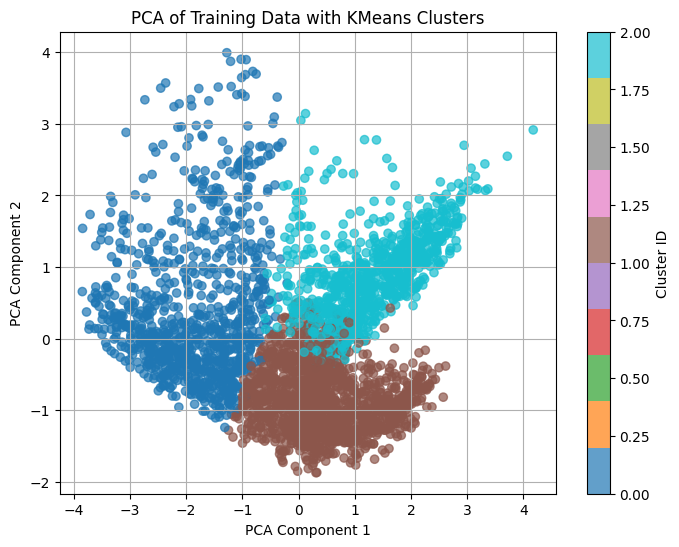

In [20]:
import matplotlib.pyplot as plt

# Assume 'train_pca' is the 2D PCA-transformed data
# and 'cluster' column contains cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Training Data with KMeans Clusters')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


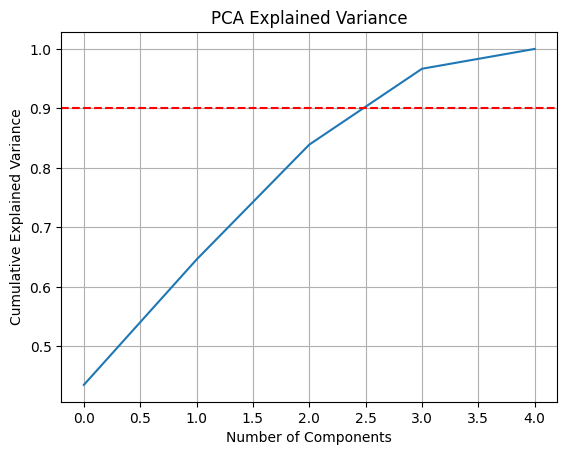

In [21]:

# Refit PCA with all components
pca_full = PCA().fit(train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [22]:
explained = pca.explained_variance_ratio_.sum()
print(f"PCA explains {explained:.2%} of the variance")

PCA explains 96.67% of the variance


In [23]:
train.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,cluster_0,cluster_1,cluster_2
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,False,False,True
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,False,False,True
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,True,False,False
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,False,False,True
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,False,False,True


## Prediction using Logistic Regression, XGBoost or LightGBM

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def create_pipeline(lag_columns, n_lags, clf, include_target_lags=True):
    steps = [
        ('feature_eng', SeasonMonthTransformer()),
        ('additional_fe', AdditionalFeatureTransformer()),
        ('lag_features', LagFeatureTransformer(columns=lag_columns, n_lags=n_lags, include_target_lags=include_target_lags)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ]
    return Pipeline(steps)

# Define your feature columns and data
features = [*config["features"], *[c for c in train.columns if c.startswith('cluster')]]

X = train[features]
y = train['rainfall']

# Create the logistic regression pipeline
pipeline_lg = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LogisticRegression(
        penalty='l1',        # L1 (Lasso) regularization
        C=1.0,               # adjust for stronger/weaker regularization
        max_iter=1000,
        random_state=42,
        solver='liblinear'   # supports L1 penalty
    ),
    include_target_lags = True
)

# Create the XGBoost pipeline 
pipeline_xgb = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=XGBClassifier(
        device=config["device"],
        n_estimators=config["n_estimators"],
        learning_rate=0.1,
        max_depth=6,
#        early_stopping_rounds=100,
        alpha=0.1,
        random_state=42,
        colsample_bytree=0.9, 
        subsample=0.9,
        use_label_encoder=False,    # Disable label encoder to avoid warnings
        eval_metric='auc'           # Set evaluation metric to AUC
    ),
    include_target_lags = True
)

# Create the XGBoost pipeline (with a different lag configuration)
pipeline_lgbm = create_pipeline(
    n_lags = config["n_lags"],
    lag_columns = config["lag_columns"],
    clf=LGBMClassifier(
        device="cpu", # config["device"], # lightGBM not compiled for CUDA in this environment
        n_estimators=config["n_estimators"],
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1  # This will suppress the warnings
    ),
    include_target_lags = True
)



Logistic Regression Repeated CV AUC scores: [0.77413516 0.74555988 0.75632621 0.73156765 0.75207297 0.78525763
 0.75492859 0.77184665 0.69033265 0.76374988 0.78406072 0.75128466
 0.75319481 0.71766657 0.74600527 0.73892862 0.7718587  0.7659643
 0.73611355 0.77388547 0.74610033 0.75011235 0.75169252 0.73798654
 0.76290118 0.73871454 0.76054591 0.73703053 0.74836601 0.76519364
 0.74796867 0.74132979 0.76208175 0.78130914 0.69133743 0.77147862
 0.75588597 0.75657009 0.74008389 0.72988977 0.75191943 0.75631582
 0.72716808 0.75985757 0.77140767 0.75514037 0.74859811 0.75744805
 0.73181153 0.77546581]
Mean AUC Logistic Regression: 0.7515


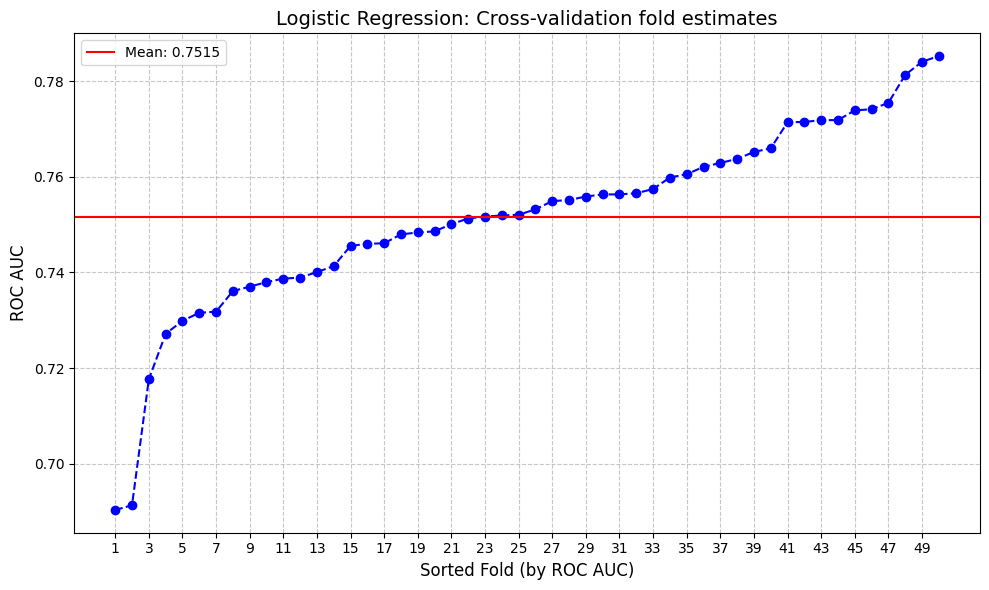

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


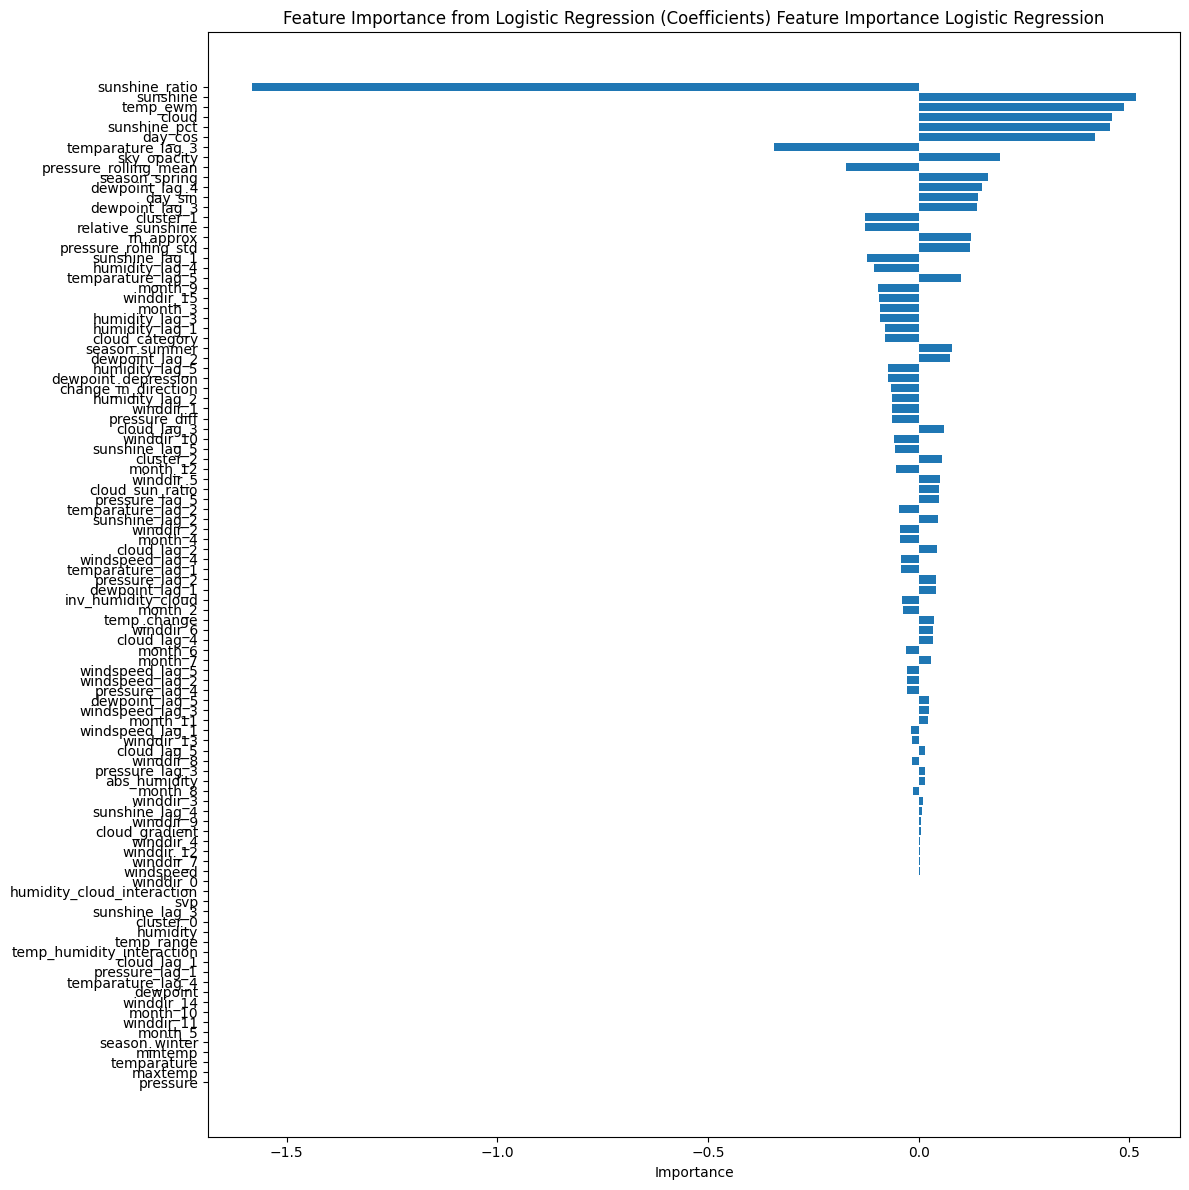

In [25]:
cv_scores_lg   = evaluate_pipeline(pipeline_lg, X, y, "Logistic Regression")
mean_cv_scores_lg = np.mean(cv_scores_lg)
pipeline_lg.fit(X, y)
plot_feature_importance(pipeline_lg, X, "Feature Importance Logistic Regression")

LightGBM Repeated CV AUC scores: [0.75750499 0.73175593 0.75212174 0.75519462 0.71091601 0.74974943
 0.74760165 0.79470296 0.68083114 0.73924495 0.77519584 0.72425314
 0.72438786 0.72314896 0.75385816 0.74627548 0.75030773 0.71564725
 0.7270998  0.76253048 0.75655136 0.72443876 0.73320652 0.70335577
 0.77040289 0.73971683 0.72985092 0.72835821 0.70703346 0.76836406
 0.70483141 0.73835994 0.75195591 0.76425715 0.69126914 0.74612952
 0.74773842 0.73822066 0.73596722 0.73795727 0.74487423 0.72184991
 0.73960589 0.76498878 0.73924495 0.73493894 0.7471718  0.76236465
 0.74600527 0.74413228]
Mean AUC LightGBM: 0.7397


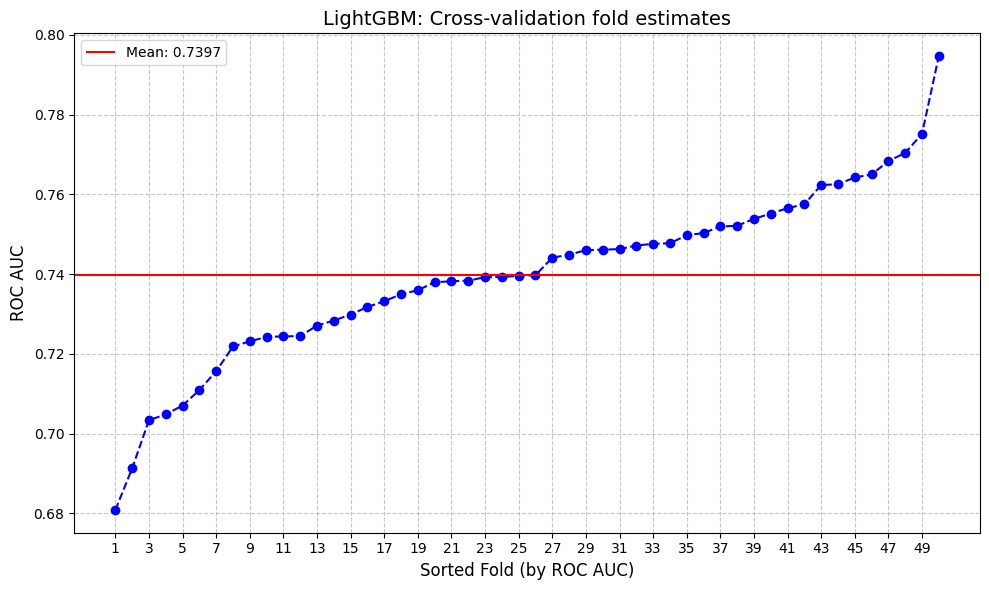

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


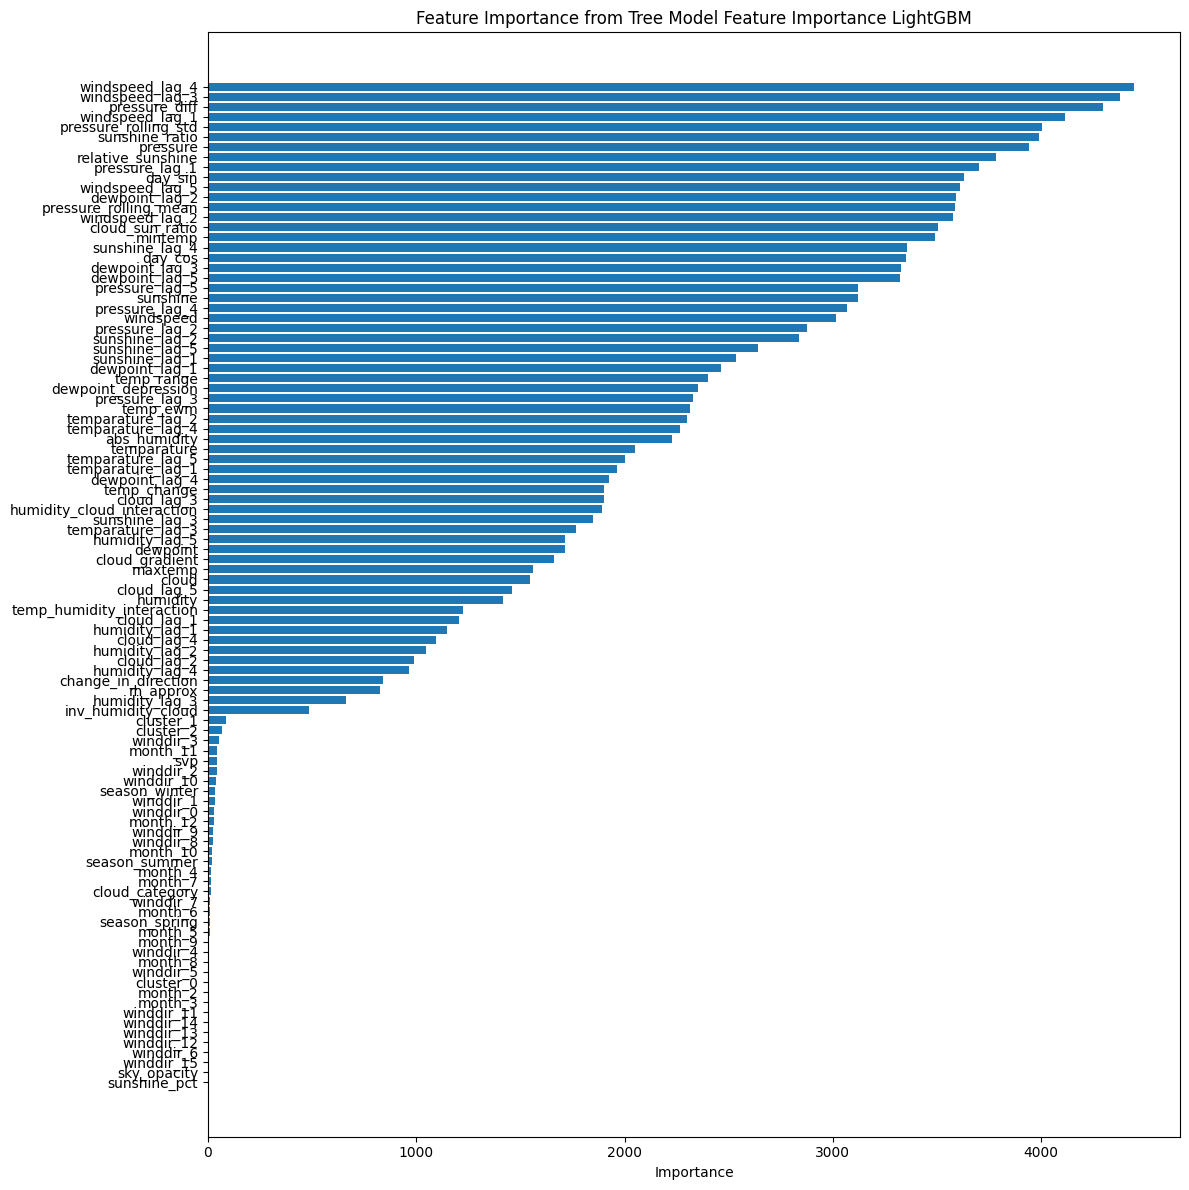

In [26]:
cv_scores_lgbm = evaluate_pipeline(pipeline_lgbm, X, y, "LightGBM")
mean_cv_scores_lgbm = np.mean(cv_scores_lgbm)
pipeline_lgbm.fit(X, y)
plot_feature_importance(pipeline_lgbm, X, "Feature Importance LightGBM")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:23:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Repeated CV AUC scores: [0.74860118 0.73034915 0.75903814 0.73743049 0.70492635 0.7531358
 0.74379164 0.78956199 0.68423568 0.73247976 0.76962974 0.72838553
 0.72659253 0.71479856 0.75913569 0.74735562 0.75447432 0.72351966
 0.72160765 0.7565018  0.76473508 0.71851371 0.72941664 0.7082431
 0.78022632 0.73063786 0.74069479 0.73328456 0.71542289 0.77451956
 0.7027052  0.73843809 0.75187787 0.76375963 0.67884109 0.74291831
 0.75273539 0.74018145 0.74045459 0.74159594 0.76491023 0.72588949
 0.72711931 0.75927227 0.74505902 0.72427383 0.7435181  0.75936006
 0.7469759  0.74335187]
Mean AUC XGBoost: 0.7395


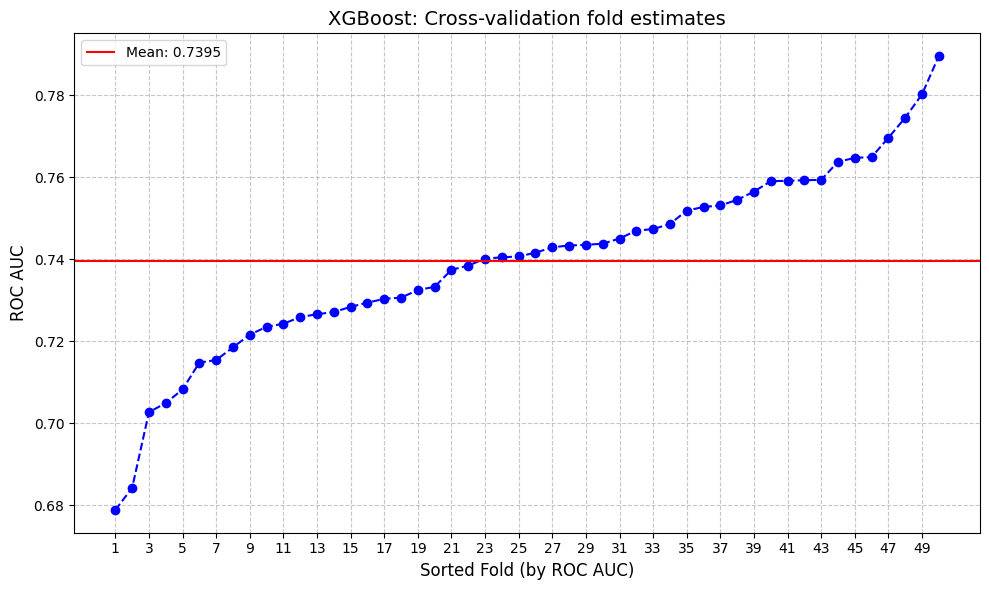

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


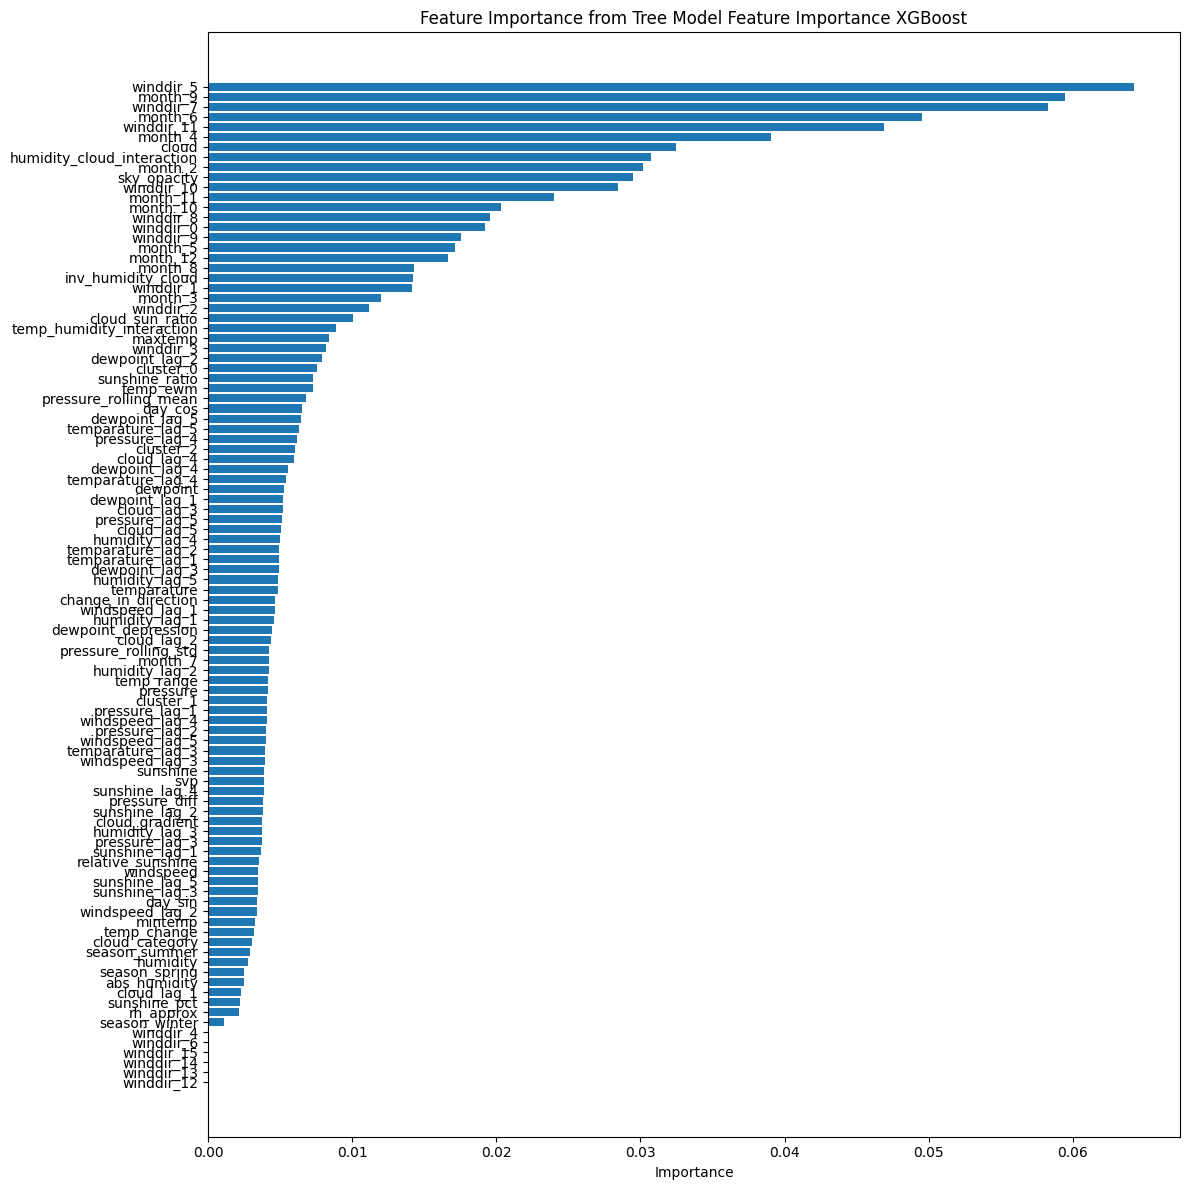

In [27]:
cv_scores_xgb  = evaluate_pipeline(pipeline_xgb, X, y, "XGBoost")
mean_cv_scores_xgb = np.mean(cv_scores_xgb)
pipeline_xgb.fit(X, y)
plot_feature_importance(pipeline_xgb, X, "Feature Importance XGBoost")


## Choose a model

Modify this variable to choose which model to submit

## Fitting model

In [28]:
# Refit on the full training set to ensure coefficients are available
#pipeline.fit(X, y)


## Creating Submission file

In [29]:
X_test = test[features]
X_test

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,cluster_0,cluster_1,cluster_2
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,False,False,True
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,False,False,True
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,False,False,True
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,False,False,True
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,False,True,False
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,False,True,False
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,False,True,False
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,False,True,False


In [30]:
# Build the ensemble using the prediction pipelines:
from sklearn.ensemble import VotingClassifier

results = {
    "LG": mean_cv_scores_lg,
    "XGB": mean_cv_scores_xgb,
    "LGBM": mean_cv_scores_lgbm
}
total_score = mean_cv_scores_lg + mean_cv_scores_xgb + mean_cv_scores_lgbm
weights = [mean_cv_scores_lg / total_score, mean_cv_scores_xgb / total_score, mean_cv_scores_lgbm / total_score]

ensemble = VotingClassifier(estimators=[
    ('LG', pipeline_lg),
    ('XGB', pipeline_xgb),
    ('LGBM', pipeline_lgbm)
], voting='soft', weights=weights)

# Fit the ensemble on the training set (using X that includes rainfall so that feature engineering runs as in training)
ensemble.fit(X, y)

## Predict on test data (which does NOT include rainfall)
#test_preds = ensemble.predict_proba(X_test)[:, 1]


VotingClassifier(estimators=[('LG',
                              Pipeline(steps=[('feature_eng',
                                               SeasonMonthTransformer()),
                                              ('additional_fe',
                                               AdditionalFeatureTransformer()),
                                              ('lag_features',
                                               LagFeatureTransformer(columns=['humidity',
                                                                              'temparature',
                                                                              'pressure',
                                                                              'cloud',
                                                                              'windspeed',
                                                                              'dewpoint',
                                                                              'sunshine'])),
                                              ('imputer', SimpleImputer()),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LogisticRegression...
                                               LagFeatureTransformer(columns=['humidity',
                                                                              'temparature',
                                                                              'pressure',
                                                                              'cloud',
                                                                              'windspeed',
                                                                              'dewpoint',
                                                                              'sunshine'])),
                                              ('imputer', SimpleImputer()),
                                              ('scaler', StandardScaler()),
                                              ('clf',
                                               LGBMClassifier(device='cpu',
                                                              max_depth=6,
                                                              n_estimators=100000,
                                                              random_state=42,
                                                              verbose=-1))]))],
                 voting='soft',
                 weights=[0.33689853235166994, 0.3315014817377382,
                          0.33159998591059187])

In [31]:
ensemble.predict_proba(X_test)

array([[0.04707399, 0.95292601],
       [0.04505175, 0.95494825],
       [0.07552311, 0.92447689],
       ...,
       [0.74883564, 0.25116437],
       [0.72571876, 0.27428125],
       [0.78530041, 0.21469959]])

In [32]:
def iterative_predict(pipeline, transformer, test_df, train_last_rainfall, train_feature_names, lag_feature_name="rainfall_lag_1"):
    """
    Iteratively predicts test data, updating the lag feature with each prediction, 
    while ensuring the transformed features match the training set.
    
    Parameters:
        pipeline: The fitted classifier (or ensemble) from your pipeline.
        transformer: A Pipeline containing the transformation steps (all steps except the classifier).
        test_df: DataFrame of raw test features (must include all columns present during training).
        train_last_rainfall: The last known rainfall value from the training set.
        train_feature_names: The list of feature names produced by transformer on training data.
        lag_feature_name: The column name for the lagged rainfall feature.
        
    Returns:gtr
        A list of predicted probabilities for each test row.
    """
    test = test_df.copy()
    predictions = []
    last_value = train_last_rainfall  # initialize with last known rainfall from training
    
    # Iterate over test rows in time order
    for idx in test.index:
        # Update the lag column with the latest known/predicted value
        test.loc[idx, lag_feature_name] = last_value
        
        # Transform the current row using the transformer
        X_current = test.loc[[idx]]
        X_current_trans = transformer.transform(X_current)
        # Reindex to ensure the columns match those from training
        X_current_trans = X_current_trans.reindex(columns=train_feature_names, fill_value=0)
        
        # Get the predicted probability
        pred_prob = pipeline.predict_proba(X_current_trans)[:, 1][0]
        predictions.append(pred_prob)
        
        # Update last_value for the next iteration
        last_value = pred_prob
    
    return predictions

# ------------------------------------------------------------------------------
# Setup: Extract transformation pipeline and training feature names

# Use one of your pipelines (here pipeline_lg) as representative
# Extract only the custom transformation steps that return a DataFrame
transformer = Pipeline(pipeline_lg.steps[:1])
train_trans = transformer.transform(X)
train_feature_names = train_trans.columns


# Get the last rainfall value from training (to initialize the lag)
train_last_rainfall = train['rainfall'].iloc[-1]

# Ensure that the test DataFrame has the 'rainfall_lag_1' column (even if as placeholder)
if "rainfall_lag_1" not in test.columns:
    test["rainfall_lag_1"] = np.nan

# Use the iterative_predict function with your ensemble (or any pipeline)
test_preds = iterative_predict(ensemble, transformer, test, train_last_rainfall, train_feature_names, lag_feature_name="rainfall_lag_1")


In [33]:
#pipeline.fit(X,y)
# Predict probabilities on the test set
#test_preds = pipeline.predict_proba(X_test)[:, 1]

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'rainfall': test_preds
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


In [34]:
test_preds[0:10]

[0.9529152672869816,
 0.9579521161940399,
 0.9012848853416524,
 0.05166466834578427,
 0.04017913401825164,
 0.8893795821957087,
 0.9307623943138847,
 0.9488173226380444,
 0.9338610703029131,
 0.8384784389303813]

In [35]:
submission.head()

,id,rainfall
0,2190,0.952915
1,2191,0.957952
2,2192,0.901285
3,2193,0.051665
4,2194,0.040179


<Axes: xlabel='rainfall', ylabel='Count'>

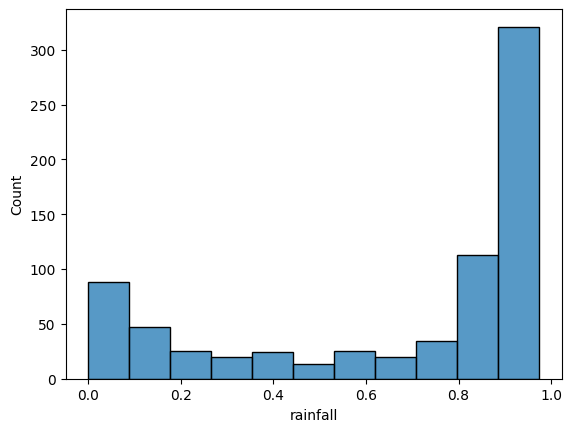

In [36]:
sns.histplot(submission, x="rainfall")